# Detección de anomalías en tiempo real mediante aprendizaje no supervisado en la telemetrías de vehículos espaciales

In [1]:
# Importado de las bibliotecas generales a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Se cargan los datos de los archivos CSV
data0 = pd.read_csv('/datasets/satellite/power--2008-08-22_2010-07-10.csv', nrows=6e5)
data_events = pd.read_csv('/datasets/satellite/context--2008-08-22_2010-07-10--evtf.csv')
data_saaf = pd.read_csv('/datasets/satellite/context--2008-08-22_2010-07-10--saaf.csv')

In [9]:
# Se eliminan las filas que no contengas eventos de eclipse 
data_events = data_events[data_events['description'].str.contains('UMBRA')]
data_events.reset_index(drop=True, inplace=True)

## Añadir información al DataFrame de datos a analizar

Se añaden las columnas con los ángulos del orbitador y la clasificación de la medida, en función de si se realizó 
durante un periodo en el cual el orbitador se encontraba en sombra, penumbra o iluminado.

Para averiguar el valor de los ángulos se va a usar el último valor conocido en el momento de la medida. Aunque con
una interpolación lineal entre el valor anterior y posterior a la medida probablemente se obtendría un valor más cercano
al real en el instante de la medida, para simular posteriormente el flujo de datos se van a ignorar aquellos datos que no
podrían ser conocidos en el momento de la medida.

Para determinar si durante la medida el orbitador se encontraba en sombra, penumbra o iluminado se va usar el registro de eventos,
usando el último evento conocido durante la medida para averiguar la situación del mismo.

In [10]:
# Creación de las columnas vacías
angle = ['sa','sx','sy','sz']
for i in range(len(angle)):
    data0[angle[i]] = pd.Series(dtype='float')
data0['state'] = pd.Series(dtype='str')

In [11]:
# Contadores para los DataFrame con los datos de los ángulos y eventos
k = 0
m = 0

# Se determina si en la primera medida el orbitador está en sombra, penumbra o iluminado
if 'PENUMBRA_START' in data_events.loc[0,'description']:
    L = 'LIGHT'
elif '_UMBRA_START' in data_events.loc[0,'description']:
    L = 'PENUMBRA'
elif '_UMBRA_END' in data_events.loc[0,'description']:
    L = 'UMBRA'
elif 'PENUMBRA_END' in data_events.loc[0,'description']:
    L = 'PENUMBRA'
else:
    sys.exit("Primer evento no encontrado")

# Se recorren todas las filas del DataFrame con las medidas a analizar
for i in range(data0.shape[0]):
    
    # Añadido de las columnas de los ángulos
    while k<data_saaf.shape[0] and i<data0.shape[0]:
        if data0.loc[i,'ut_ms']==data_saaf.loc[k,'ut_ms']:
            for j in range(len(angle)):
                data0.loc[i,angle[j]] = data_saaf.loc[k,angle[j]]
            k+=1
            break
        elif k==0 and data0.loc[i,'ut_ms']<data_saaf.loc[k,'ut_ms']:
            for j in range(len(angle)):
                data0.loc[i,angle[j]] = data_saaf.loc[k,angle[j]]
            break
        elif data0.loc[i,'ut_ms']<data_saaf.loc[k,'ut_ms']:
            for j in range(len(angle)):
                data0.loc[i,angle[j]] = data_saaf.loc[k-1,angle[j]]
            break
        else:
            k+=1
                
    # Añadido de la columna de la clasificación
    while m<data_events.shape[0] and i<data0.shape[0]:
        if data0.loc[i,'ut_ms']<data_events.loc[m,'ut_ms']:
            data0.loc[i,'state'] = L
            break
        else:
            if 'PENUMBRA_START' in data_events.loc[m,'description']:
                L = 'PENUMBRA'
            elif '_UMBRA_START' in data_events.loc[m,'description']:
                L = 'UMBRA'
            elif '_UMBRA_END' in data_events.loc[m,'description']:
                L = 'PENUMBRA'
            elif 'PENUMBRA_END' in data_events.loc[m,'description']:
                L = 'LIGHT'
            else:
                sys.exit("Evento no encontrado")
            
            m+=1

In [12]:
# Guardado de los datos con la nueva información añadida
from pathlib import Path  
filepath = Path('data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data0.to_csv(filepath, index=False)  

## Cargado de los datos

In [13]:
# Cargado de los datos guardados
data0 = pd.read_csv('data.csv')

## Estudio inicial de los datos

Ya que la cantidad de muestras es muy alta incluso no habiendo cargado el dataset completo, se va a estudiar la distribución y como afecta
el estado de las muestras a los valores de las medidas para escoger un intervalo de muestras y una medida en concreto con la que sea 
interesante trabajar.

state
LIGHT       581205
PENUMBRA       480
UMBRA        18315
Name: state, dtype: int64


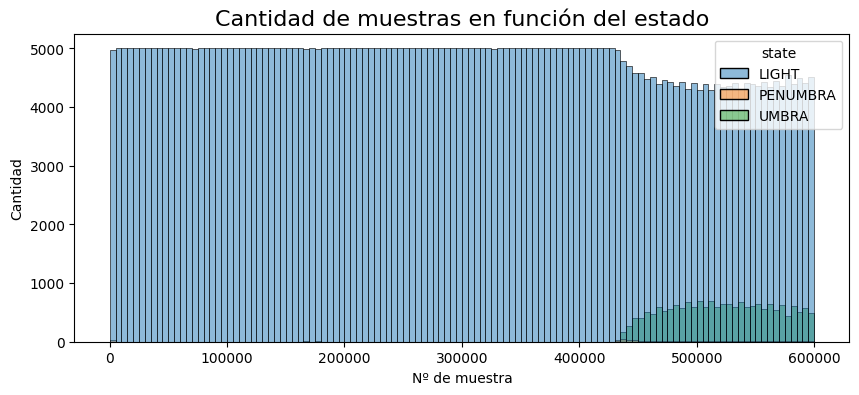

In [14]:
print(data0.groupby('state')['state'].count()) # Cantidad de muestras agrupadas por el estado

fig, ax = plt.subplots(figsize = ( 10 , 4 ))

sns.histplot(ax = ax, data=data0, x=data0.index, hue='state', binwidth=5000)
ax.set_xlabel( "Nº de muestra" , size = 10 )
ax.set_ylabel( "Cantidad" , size = 10 )
ax.set_title( "Cantidad de muestras en función del estado" , size = 16 )
plt.show()

Se va a escoger el intervalo entre la muesta 500000 y 505000 ya que es el intervalo donde mas frecuentemente aparecen medidas hechas mientras
el orbitador se encontraba en sombra. Creo que la variedad provocada por los eclipses puede ser la más interesante de cara a la detección
de anomalías.

In [15]:
# Seleccionar el intervalo de muestras entre 500000 y 550000
data_interval = data0.loc[500000:505000, :]
data_interval.reset_index(drop=True, inplace=True)

# Seleccionaar solo las columnas con los valores de corriente y clasificación
cols = data_interval.columns.tolist()
cols = cols[1:-5] + cols[-1:]

# Calcular la diferencia de porcentaje relativa entre la media cuando el orbitador esta iluminado o en sombra
mean_values = data_interval.loc[:, cols].groupby('state').mean().transpose()
mean_values['difference'] = np.abs(mean_values['LIGHT'] - mean_values['UMBRA'])/((mean_values['LIGHT'] + mean_values['UMBRA'])/2)*100
print(mean_values[['difference']].sort_values(by='difference', ascending=False))

state     difference
NPWD2851   56.803875
NPWD2551   53.015464
NPWD2372   19.392650
NPWD2791   14.925909
NPWD2491   11.168499
NPWD2721    9.655319
NPWD2451    6.329385
NPWD2802    5.238509
NPWD2561    1.443631
NPWD2532    1.320707
NPWD2771    0.984473
NPWD2481    0.705825
NPWD2531    0.696156
NPWD2801    0.494748
NPWD2472    0.464565
NPWD2881    0.425660
NPWD2501    0.410817
NPWD2482    0.346333
NPWD2852    0.342835
NPWD2792    0.336294
NPWD2872    0.259905
NPWD2471    0.205422
NPWD2882    0.200247
NPWD2691    0.188638
NPWD2401    0.181453
NPWD2692    0.173397
NPWD2742    0.146115
NPWD2562    0.112928
NPWD2871    0.091613
NPWD2552    0.057949
NPWD2402    0.014570
NPWD2821    0.006956
NPWD2722    0.002347


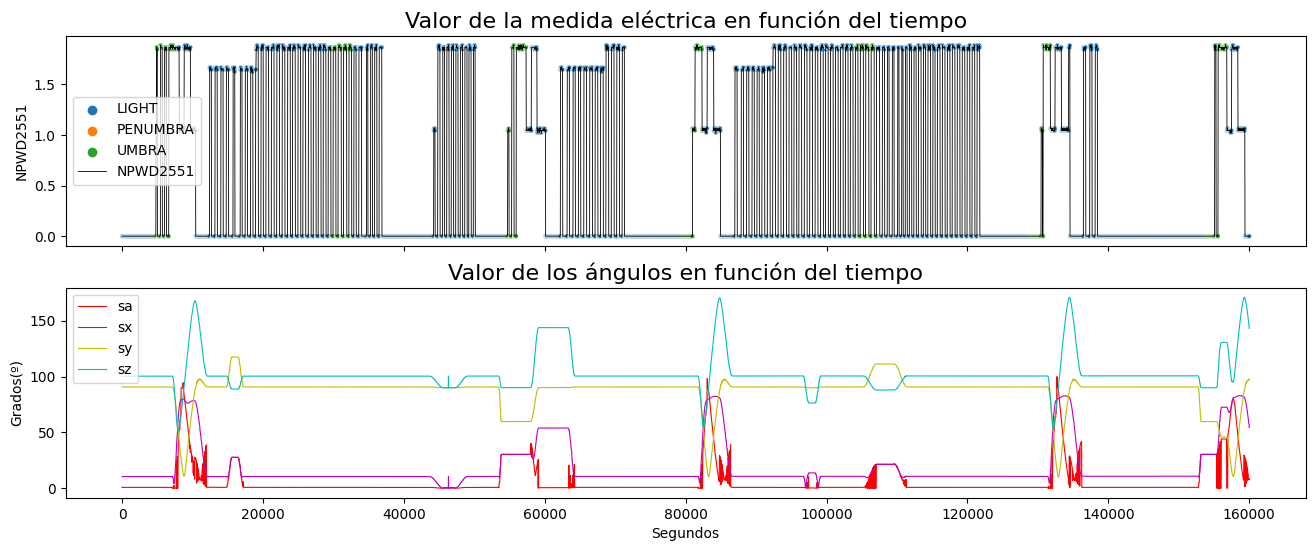

In [83]:
value = 'NPWD2551' # Se escoge un medida de corriente en concreto
data_final = data_interval.loc[:,['ut_ms',value,'sa','sx','sy','sz','state']]
data_final = data_final.loc[0:5000,:] # Por si se quieren escoger unas filas en concreto

# ut_ms pasado a segundos y que comience en 0
data_final['ut_ms'] = (data_final['ut_ms']-data_final['ut_ms'].min())/1000

# Visualizado del valor de la corriente a lo largo del tiempo junto con los ángulos y
# el estado del orbitador en el momento de la medida
fig, ax = plt.subplots(2, 1, sharex=True, figsize = ( 16 , 6 ))
sns.scatterplot(ax=ax[0], data=data_final, x='ut_ms', y=value, hue='state', s=10)
sns.lineplot(ax=ax[0], data=data_final, x='ut_ms', y=value, color='k', linewidth=0.6, label=value)
ax[0].set_ylabel(value, size = 10 )
ax[0].set_title("Valor de la medida eléctrica en función del tiempo", size = 16 )
sns.lineplot(ax=ax[1], data=data_final, x='ut_ms', y='sa', color='r', linewidth=0.8, label='sa')
sns.lineplot(ax=ax[1], data=data_final, x='ut_ms', y='sx', color='m', linewidth=0.8, label='sx')
sns.lineplot(ax=ax[1], data=data_final, x='ut_ms', y='sy', color='y', linewidth=0.8, label='sy')
sns.lineplot(ax=ax[1], data=data_final, x='ut_ms', y='sz', color='c', linewidth=0.8, label='sz')
ax[1].set_xlabel("Segundos", size = 10 )
ax[1].set_ylabel('Grados(º)', size = 10 )
ax[1].set_title("Valor de los ángulos en función del tiempo", size = 16 )
plt.show()
# Periodo orbital de aproximadamente 25000 segundos (800 muestras)

A pesar de haber escogido el valor que tenía más diferencia relativa entre la media del mismo en estado iluminado y en sombra,
no parece que haya una relación clara entre el valor de la medida, el estado y los valores de los ángulos.

## Detección de anomalías

In [7]:
# Importado de los métodos de detección de anomalías
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
# Método de estandarizado
from sklearn.preprocessing import StandardScaler
# Biblioteca para medir tiempos de procesamiento
import time

### Usando solamente el valor de la corriente eléctrica

Se va a utilizar de primer intento únicamente el valor de la corriente. Esto implica que el método de detección de anomalías solo
va a tener en cuenta el valor de las n medidas anteriores, independientemente de si la medida fue tomada más pronto o más
tarde dentro de ese intervalo.

In [84]:
# Parámetros generales
n = 1000
cont = 0.01

# Datos iniciales
X = data_final.loc[0:n,[value]].to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(X) # Estandarización

# Isolation Forest permite entrenar el modelo con los datos iniciales para más tarde 
# ir entrenado el modelo añadiendo nuevos estimadores (warm_start=True)
model_forest = IsolationForest(max_samples=n, max_features=1, contamination=0.01).fit(X)

# Comienzo del flujo de datos
pred_local = []
t_process_local = []
n_anom_local = 0
pred_forest = []
t_process_forest = []
n_anom_forest = 0
for i in range(n,data_final.shape[0]):
    
    # Se elimina la primera fila y se añade una nueva al final para mantener el tamaño de X constante 
    X = np.delete(X, 0, axis=0)
    X = np.append(X, scaler.transform([data_final.loc[i,[value]].to_numpy()]), axis=0)
    
    # Modelo Local Outlier Factor
    st = time.process_time()
    
    model_local = LocalOutlierFactor(n_neighbors=n, p=2, contamination=cont)
    if model_local.fit_predict(X)[-1]==-1:
        pred_local.append(i)
        n_anom_local += 1
    
    et = time.process_time()
    t_process_local.append(et-st)
    
    # Modelo Isolation Forest
    st = time.process_time()
    
    model_forest = IsolationForest(max_samples=n, max_features=1, contamination=cont, warm_start=True).fit(X)
    if model_forest.predict([X[-1,:]])==-1:
        pred_forest.append(i)
        n_anom_forest += 1
    
    et = time.process_time()
    t_process_forest.append(et-st)

Número de anomalías según Local Outlier Factor = 37 de 4001 muestras
Número de anomalías según Isolation Forest = 54 de 4001 muestras
Tiempo total de Local Outlier Factor = 1170.030s, con un tiempo medio por muestra de 0.292s
Tiempo total de Isolation Forest = 696.914s, con un tiempo medio por muestra de 0.174s


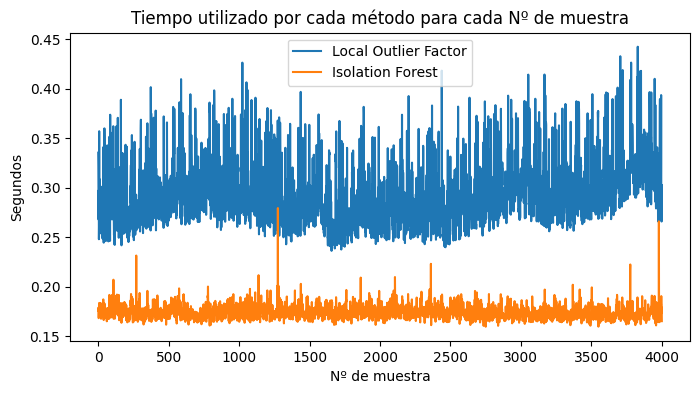

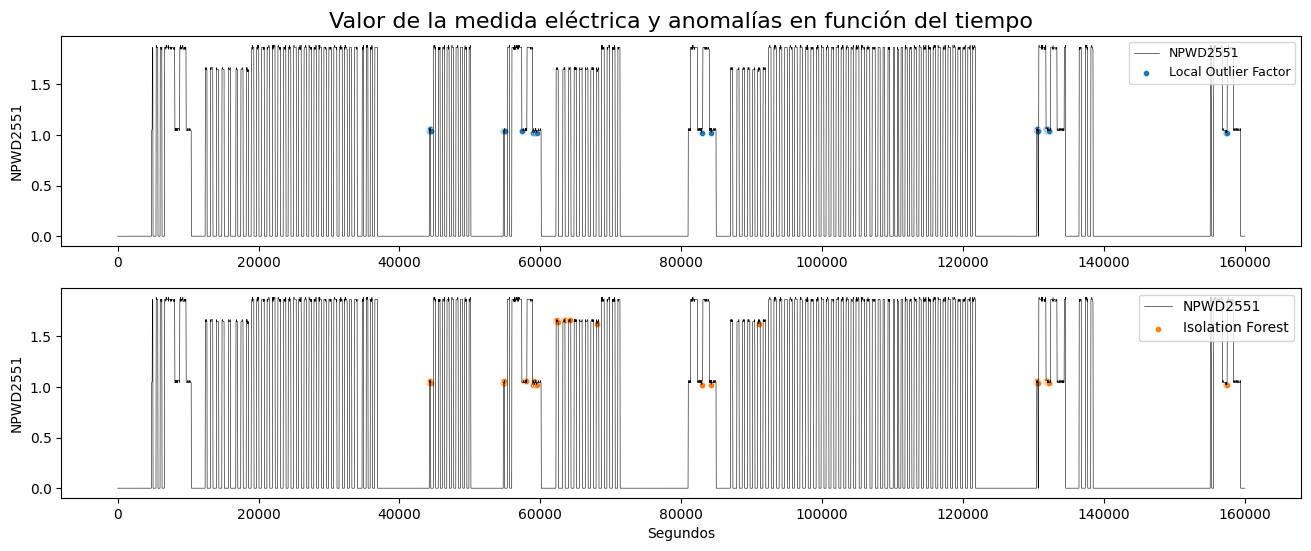

In [85]:
print('Número de anomalías según Local Outlier Factor = {:d} de {:d} muestras.'
      .format(n_anom_local,len(t_process_local)))
print('Número de anomalías según Isolation Forest = {:d} de {:d} muestras.'
      .format(n_anom_forest,len(t_process_forest)))
print('Tiempo total de Local Outlier Factor = {:.1f}s, con un tiempo medio por muestra de {:.3f}s.'
      .format(sum(t_process_local),sum(t_process_local)/len(t_process_local)))
print('Tiempo total de Isolation Forest = {:.1f}s, con un tiempo medio por muestra de {:.3f}s.'
      .format(sum(t_process_forest),sum(t_process_forest)/len(t_process_forest)))

fig, ax = plt.subplots(figsize = ( 8 , 4 ))
plt.plot(t_process_local, label='Local Outlier Factor')
plt.plot(t_process_forest, label='Isolation Forest')
plt.xlabel('Nº de muestra')
plt.ylabel('Segundos')
plt.title('Tiempo utilizado por cada método para cada Nº de muestra')
plt.legend()
plt.show()

fig, ax = plt.subplots(2, 1, sharex=False, figsize = ( 16 , 6 ))
sns.lineplot(ax=ax[0], data=data_final, x='ut_ms', y=value, color='k', linewidth=0.4, label=value)
sns.scatterplot(ax=ax[0], data=data_final.loc[pred_local,:], x='ut_ms', y=value, s=20, label='Local Outlier Factor')
ax[0].set(xlabel=None)
ax[0].set_ylabel(value, size = 10 )
ax[0].set_title("Valor de la medida eléctrica y anomalías en función del tiempo", size = 16 )
ax[0].legend(loc='upper right', fontsize='9')
sns.lineplot(ax=ax[1], data=data_final, x='ut_ms', y=value, color='k', linewidth=0.4, label=value)
sns.scatterplot(ax=ax[1], data=data_final.loc[pred_forest,:], x='ut_ms', y=value, s=20, color='tab:orange' ,label='Isolation Forest')
ax[1].set_xlabel("Segundos", size = 10 )
ax[1].set_ylabel(value, size = 10 )
ax[1].legend(loc='upper right')
plt.show()

Los puntos anómalos son en su mayoría aquellos cuyo valor apenas aparece en los anteriores 1000 puntos, lo que más o menos corresponde a
un intervalo de 30000 segundos. 

### Usando el valor de la corriente eléctrica y el tiempo

Se va a probar a utilizar también el valor del tiempo en el que se tomó la medida, por lo que ahora el hecho de que la medida
fuese hecha antes o después sí debería afectar.

In [86]:
# Parámetros generales
n = 1000
cont = 0.01

# Datos iniciales
X = data_final.loc[0:n,['ut_ms',value]].to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(X) # Estandarización

# Isolation Forest permite entrenar el modelo con los datos iniciales para más tarde 
# ir entrenado el modelo añadiendo nuevos estimadores (warm_start=True)
model_forest = IsolationForest(max_samples=n, max_features=2, contamination=0.01).fit(X)

# Comienzo del flujo de datos
pred_local = []
t_process_local = []
n_anom_local = 0
pred_forest = []
t_process_forest = []
n_anom_forest = 0
for i in range(n,data_final.shape[0]):
    
    # Se elimina la primera fila y se añade una nueva al final para mantener el tamaño de X constante
    X = np.delete(X, 0, axis=0)
    X = np.append(X, scaler.transform([data_final.loc[i,['ut_ms',value]].to_numpy()]), axis=0)
    
    # Modelo LocalOutlierFactor
    st = time.process_time()
    
    model_local = LocalOutlierFactor(n_neighbors=n, p=2, contamination=cont)
    if model_local.fit_predict(X)[-1]==-1:
        pred_local.append(i)
        n_anom_local += 1
    
    et = time.process_time()
    t_process_local.append(et-st)
    
    # Modelo IsolationForest
    st = time.process_time()
    
    model_forest = IsolationForest(max_samples=n, max_features=2, contamination=cont, warm_start=True).fit(X)
    if model_forest.predict([X[-1,:]])==-1:
        pred_forest.append(i)
        n_anom_forest += 1
    
    et = time.process_time()
    t_process_forest.append(et-st)

Número de anomalías según Local Outlier Factor = 0 de 4001 muestras
Número de anomalías según Isolation Forest = 851 de 4001 muestras
Tiempo total de Local Outlier Factor = 870.016s, con un tiempo medio por muestra de 0.217s
Tiempo total de Isolation Forest = 855.124s, con un tiempo medio por muestra de 0.214s


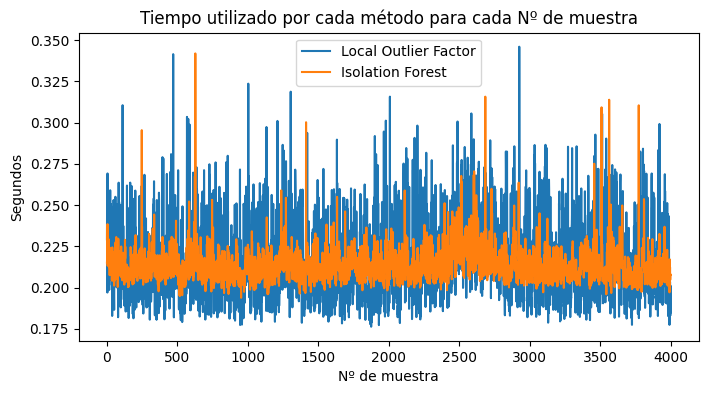

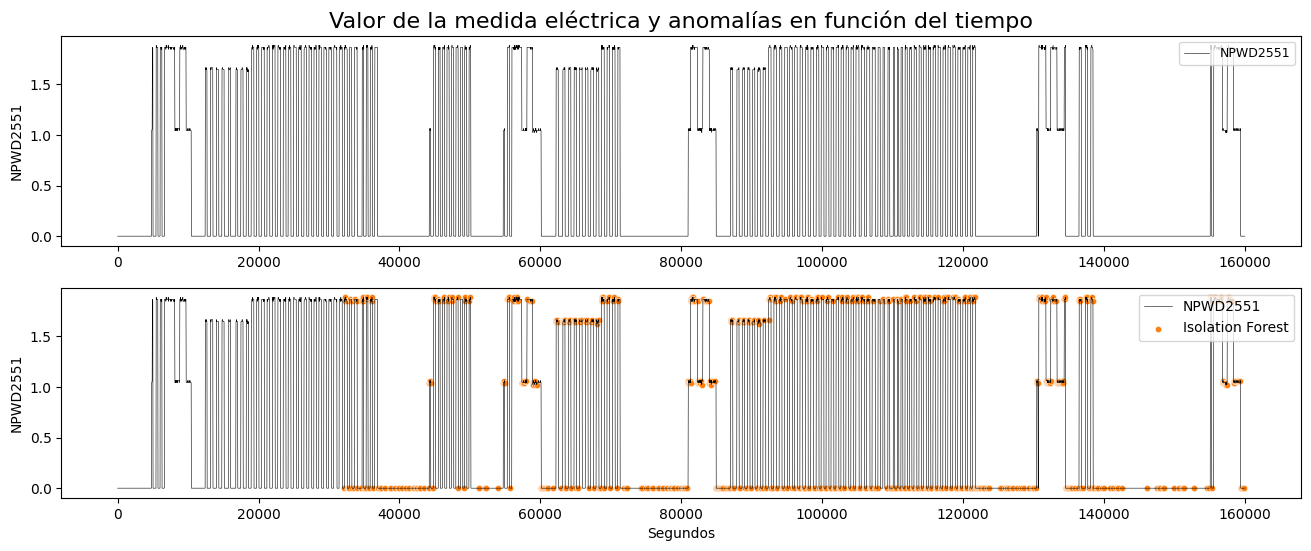

In [87]:
print('Número de anomalías según Local Outlier Factor = {:d} de {:d} muestras.'
      .format(n_anom_local,len(t_process_local)))
print('Número de anomalías según Isolation Forest = {:d} de {:d} muestras.'
      .format(n_anom_forest,len(t_process_forest)))
print('Tiempo total de Local Outlier Factor = {:.1f}s, con un tiempo medio por muestra de {:.3f}s.'
      .format(sum(t_process_local),sum(t_process_local)/len(t_process_local)))
print('Tiempo total de Isolation Forest = {:.1f}s, con un tiempo medio por muestra de {:.3f}s.'
      .format(sum(t_process_forest),sum(t_process_forest)/len(t_process_forest)))

fig, ax = plt.subplots(figsize = ( 8 , 4 ))
plt.plot(t_process_local, label='Local Outlier Factor')
plt.plot(t_process_forest, label='Isolation Forest')
plt.xlabel('Nº de muestra')
plt.ylabel('Segundos')
plt.title('Tiempo utilizado por cada método para cada Nº de muestra')
plt.legend()
plt.show()

fig, ax = plt.subplots(2, 1, sharex=False, figsize = ( 16 , 6 ))
sns.lineplot(ax=ax[0], data=data_final, x='ut_ms', y=value, color='k', linewidth=0.4, label=value)
sns.scatterplot(ax=ax[0], data=data_final.loc[pred_local,:], x='ut_ms', y=value, s=20, label='Local Outlier Factor')
ax[0].set(xlabel=None)
ax[0].set_ylabel(value, size = 10 )
ax[0].set_title("Valor de la medida eléctrica y anomalías en función del tiempo", size = 16 )
ax[0].legend(loc='upper right', fontsize='9')
sns.lineplot(ax=ax[1], data=data_final, x='ut_ms', y=value, color='k', linewidth=0.4, label=value)
sns.scatterplot(ax=ax[1], data=data_final.loc[pred_forest,:], x='ut_ms', y=value, s=20, color='tab:orange' ,label='Isolation Forest')
ax[1].set_xlabel("Segundos", size = 10 )
ax[1].set_ylabel(value, size = 10 )
ax[1].legend(loc='upper right')
plt.show()

El problema con tener en cuenta el tiempo es que se crea una dispersión de puntos tal y como la del gráfico temporal normal,
es decir, Local Outlier Factor no va a detectar anomalías porque la densidad de puntos es similar en todos ellos e Isolation Forest
va a detectar casi todos los puntos como anomalías porque el punto a evaluar siempre va a estar en el extremo derecho, el último de todos.